# Introduction

This tutorial demonstrates how to compute a kinematic electron diffraction pattern simulation.

The code functionality is illustrated using a simple cubic crystal, which is first generated using `diffpy`. The intention is for this to provide an easy to understand illustration of the code functionality rather than to model any physical system.

UPDATE THIS This functionaility has been checked to run in pyxem-0.10.0 (November 2019). Bugs are always possible, do not trust the code blindly, and if you experience any issues please report them here: https://github.com/pyxem/pyxem-demos/issues

# Contents

1. <a href='#gen'> Setting up & Creating Synthetic Data</a>
2. <a href='#aff'> Diffraction simulation</a>

# <a id='gen'></a> 1. Setting up & Creating Crystal

Import pyxem and other required libraries

In [1]:
# %matplotlib tk
%matplotlib notebook
import numpy as np
import diffsims as ds
import diffpy.structure
from diffpy.structure.expansion import supercell
from matplotlib import pyplot as plt
from time import time

Define a structure for the creation of synthetic data

In [2]:
latt = diffpy.structure.lattice.Lattice(2,2,2,90,90,90)
atom = diffpy.structure.atom.Atom(atype='Si',xyz=[0,0,0],lattice=latt)
structure = diffpy.structure.Structure(atoms=[atom],lattice=latt)
structure = supercell(structure, (70, 70, 30)) # 70x70x30 mesh of atoms spaced 2A apart
c = structure.xyz_cartn.reshape(-1,3).max(0)/2 # Centre of crystal

Define spatial coordinates on which to discretise in real and reciprocal space and initialise probe of width 5 angstroms.

In [3]:
real_grid, recip_grid = ds.getRecipPoints(2, dX=.2, rX=40)
probe = ds.BesselProbe(5)

Discretise and plot the volume

<IPython.core.display.Javascript object>


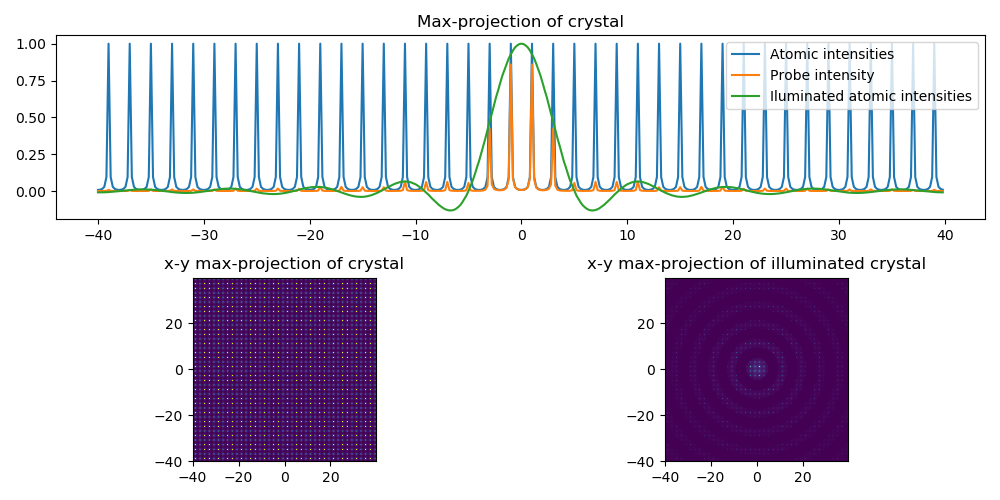

'Volume discretisation and plotting: 5.27s'

In [4]:
x = ds.getRecipPoints(3, dX=.2, rX=80)[0]
tic = time()
vol = ds.getDiscretisation(structure.xyz_cartn-c, 14, x, pointwise=True, ZERO=1e-5)
vol /= vol.max()
p_vol = vol*2*probe(x)
plt.figure('volume', figsize=(10,5))
mid = tuple(s//2 for s in vol.shape)
plt.subplot(211)
plt.plot(x[0],vol.max((1,2)), x[0],p_vol.max((1,2)), x[0], 2*probe(x)[:,mid[1],mid[2]])
plt.legend(('Atomic intensities', 'Probe intensity', 'Iluminated atomic intensities'), loc='upper right')
plt.title('Max-projection of crystal')
plt.subplot(223)
plt.imshow(vol.max(2)**.5, aspect='equal', origin='lower', extent=[x[0][0], x[0][-1], x[1][0], x[1][-1]])
plt.title('x-y max-projection of crystal')
plt.subplot(224)
plt.imshow(p_vol.max(2)**.5, aspect='equal', origin='lower', extent=[x[0][0], x[0][-1], x[1][0], x[1][-1]])
plt.title('x-y max-projection of illuminated crystal')
plt.tight_layout()
'Volume discretisation and plotting: %.2fs'%(time()-tic)

# <a id='aff'></a> 2. Diffraction Simulation

Standard diffraction pattern

In [5]:
tic = time()
ediff = ds.AtomicDiffractionGenerator(300, real_grid)
diff_plain = ediff.calculate_ed_data(structure, probe, slice_thickness=1, probe_centre=c[:2])
'Standard diffraction pattern: %.2fs'%(time()-tic)

'Standard diffraction pattern: 7.44s'

Defined on reciprocal grid, equivalent to standard call.

In [6]:
tic = time()
ediff = ds.AtomicDiffractionGenerator(300., recip_grid, reciprocal_mesh=True)
diff_recip = ediff.calculate_ed_data(structure, probe, slice_thickness=1, probe_centre=c[:2])
'Input reciprocal mesh: %.2fs'%(time()-tic)

'Input reciprocal mesh: 6.52s'

Diffraction pattern with precession

In [7]:
tic = time()
ediff = ds.AtomicDiffractionGenerator(300., real_grid)
diff_prec = ediff.calculate_ed_data(structure, probe, slice_thickness=1, probe_centre=c[:2],
                                    precessed=(1.0, 30))
'Precessed diffraction pattern: %.2fs'%(time()-tic)

'Precessed diffraction pattern: 16.29s'

High energy limit, beam energy can be set to 'inf' for faster computation.

In [8]:
tic = time()
ediff = ds.AtomicDiffractionGenerator('inf', real_grid)
diff_flat = ediff.calculate_ed_data(structure, probe, slice_thickness=1, probe_centre=c[:2])
'High energy limit: %.2fs'%(time()-tic)

'High energy limit: 2.60s'

Other efficiency parameters include setting `dtype` and `ZERO` threshold (values below this will be set to 0 during the volume discretisation) or changing the `pointwise` flag. Setting `dtype` is mainly an advantage during precession where the cost of a Fourier transform dominates, `ZERO` and `pointwise` are more useful for speeding up initial discretisation. By default, the atomic charge within a voxel is taken to be equal to its average value whereas setting `pointwise=True` assumes that it is equal to the value at the centre of the voxel. This is accurate if the resolution is high but otherwise introduces some intensity artefacts.

In [9]:
tic = time()
ediff = ds.AtomicDiffractionGenerator(300, real_grid)
diff_fast = ediff.calculate_ed_data(structure, probe, slice_thickness=1, probe_centre=c[:2],
                                   pointwise=True, dtype='float32', ZERO=1e-4)
'Low precision: %.2fs'%(time()-tic)

'Low precision: 3.58s'

Low energy simulation to see curvature of the sphere.

In [10]:
tic = time()
fine_grid = ds.getRecipPoints(2, dX=.1, rX=40)[1]
ediff = ds.AtomicDiffractionGenerator(10, fine_grid, reciprocal_mesh=True)
diff_sphere = ediff.calculate_ed_data(structure, probe, slice_thickness=0.2, probe_centre=c[:2],
                                     pointwise=True, ZERO=1e-4)
'Low energy pattern: %.2fs'%(time()-tic)

'Low energy pattern: 24.38s'

Plot all diffraction patterns

<IPython.core.display.Javascript object>


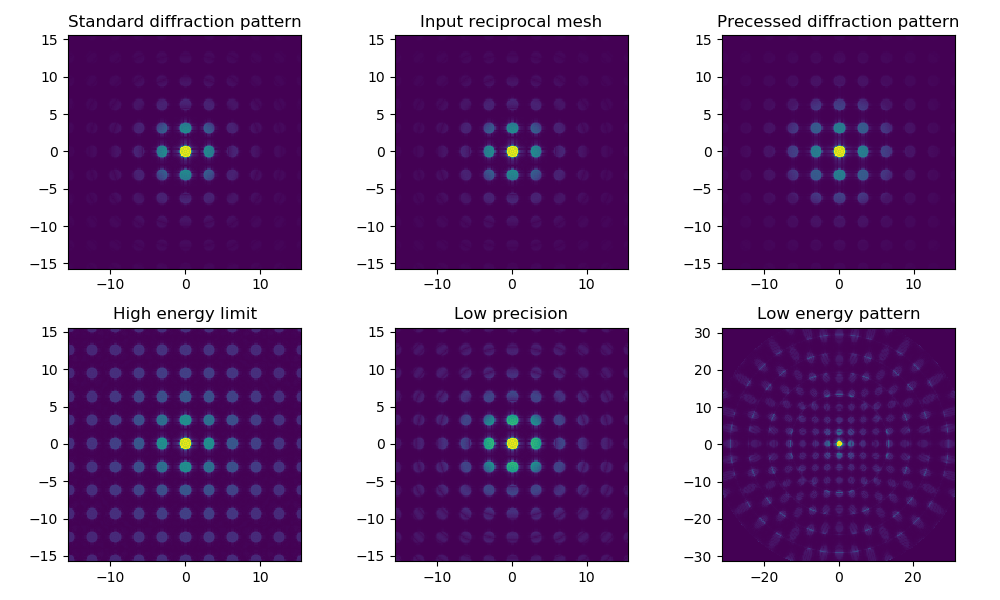

In [11]:
dps = ((diff_plain, 'Standard diffraction pattern', recip_grid, .3),
       (diff_recip, 'Input reciprocal mesh', recip_grid, .3),
       (diff_prec, 'Precessed diffraction pattern', recip_grid, .3),
       (diff_flat, 'High energy limit', recip_grid, .3),
       (diff_fast, 'Low precision', recip_grid, .3),
       (diff_sphere, 'Low energy pattern', fine_grid, .2))

plt.figure('diffraction pattern', figsize=(10,6))
for i, (arr, title, grid, p) in enumerate(dps):
    plt.subplot(2,3,i+1)
    plt.imshow(arr**p, aspect='equal', origin='lower', 
               extent=[grid[0][0], grid[0][-1], grid[1][0], grid[1][-1]])
    plt.title(title)
plt.tight_layout()